<a href="https://colab.research.google.com/github/TatianaYeremenko/ApiDataDisplay/blob/main/nba_api_notebook_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NBA API Analysis - Golden State Warriors vs Toronto Raptors
============================================================

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import numpy as np


NBA API Analysis: Warriors vs Raptors Performance

INSTALL AND IMPORT NBA API


In [2]:
# Uncomment to install if needed
!pip install nba_api

try:
    from nba_api.stats.static import teams
    from nba_api.stats.endpoints import leaguegamefinder
    print("NBA API imported successfully")
except ImportError:
    print("NBA API not installed. Run: pip install nba_api")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.3/285.3 kB 4.1 MB/s eta 0:00:00
NBA API imported successfully


Retrieving NBA Teams Data

In [3]:
def one_dict(list_dict):
    """Convert list of dictionaries to single dictionary with lists as values."""
    keys = list_dict[0].keys()
    out_dict = {key: [] for key in keys}
    for dict_ in list_dict:
        for key, value in dict_.items():
            out_dict[key].append(value)
    return out_dict

try:
    # Get all NBA teams
    nba_teams = teams.get_teams()
    print(f"Retrieved {len(nba_teams)} NBA teams")

    # Show first 10 teams
    print("\nFirst 10 teams:")
    for i, team in enumerate(nba_teams[:10]):
        print(f"   {i+1}. {team['full_name']} ({team['abbreviation']})")

    # Convert to DataFrame
    dict_nba_team = one_dict(nba_teams)
    df_teams = pd.DataFrame(dict_nba_team)

    print(f"\nTeams DataFrame shape: {df_teams.shape}")
    print("\nSample teams data:")
    print(df_teams[['full_name', 'abbreviation', 'city']].head())
except Exception as e: # This line's indentation was likely the issue
    print(f"Error retrieving teams: {e}")

Retrieved 30 NBA teams

First 10 teams:
   1. Atlanta Hawks (ATL)
   2. Boston Celtics (BOS)
   3. Cleveland Cavaliers (CLE)
   4. New Orleans Pelicans (NOP)
   5. Chicago Bulls (CHI)
   6. Dallas Mavericks (DAL)
   7. Denver Nuggets (DEN)
   8. Golden State Warriors (GSW)
   9. Houston Rockets (HOU)
   10. Los Angeles Clippers (LAC)

Teams DataFrame shape: (30, 7)

Sample teams data:
              full_name abbreviation         city
0         Atlanta Hawks          ATL      Atlanta
1        Boston Celtics          BOS       Boston
2   Cleveland Cavaliers          CLE    Cleveland
3  New Orleans Pelicans          NOP  New Orleans
4         Chicago Bulls          CHI      Chicago


Finding Golden State Warriors

In [4]:
try:
    # Find Warriors by nickname
    df_warriors = df_teams[df_teams['nickname'] == 'Warriors']

    if not df_warriors.empty:
        print("Warriors found:")
        print(f"   Team: {df_warriors['full_name'].iloc[0]}")
        print(f"   City: {df_warriors['city'].iloc[0]}")
        print(f"   Founded: {df_warriors['year_founded'].iloc[0]}")

        # Get Warriors ID
        id_warriors = df_warriors[['id']].values[0][0]
        print(f"   Team ID: {id_warriors}")
    else:
        print("Warriors not found")

except Exception as e:
    print(f"Error finding Warriors: {e}")

Warriors found:
   Team: Golden State Warriors
   City: Golden State
   Founded: 1946
   Team ID: 1610612744


Loud Game Data

In [5]:
#!/usr/bin/env python3
"""
Retrieve NBA team game results from the last 6 months using nba_api
Reusable for any NBA team including Warriors and Raptors
"""

from nba_api.stats.endpoints import teamgamelog
from nba_api.stats.static import teams
from datetime import datetime, timedelta
import pandas as pd

def get_team_games(team_name):
    """
    Get game results for any NBA team from the last 6 months
    Args:
        team_name (str): Full team name (e.g., "Golden State Warriors", "Toronto Raptors")
    Returns:
        DataFrame: Recent games data or None if error
    """
    try:
        # Get team ID
        team_info = teams.find_teams_by_full_name(team_name)[0]
        team_id = team_info['id']

        # Calculate date 6 months ago
        six_months_ago = datetime.now() - timedelta(days=180)
        season = "2024-25"  # Current NBA season

        # Get team game log
        gamelog = teamgamelog.TeamGameLog(
            team_id=team_id,
            season=season,
            season_type_all_star='Regular Season'
        )

        # Get games data
        games_df = gamelog.get_data_frames()[0]

        # Convert GAME_DATE to datetime with explicit format
        games_df['GAME_DATE'] = pd.to_datetime(games_df['GAME_DATE'], format='%b %d, %Y')

        # Filter games from last 6 months
        recent_games = games_df[games_df['GAME_DATE'] >= six_months_ago]

        # Sort by date (most recent first)
        recent_games = recent_games.sort_values('GAME_DATE', ascending=False)

        # Calculate home/away records
        home_games = recent_games[recent_games['MATCHUP'].str.contains('vs')]
        away_games = recent_games[recent_games['MATCHUP'].str.contains('@')]
        home_record = f"{len(home_games[home_games['WL'] == 'W'])}-{len(home_games[home_games['WL'] == 'L'])}"
        away_record = f"{len(away_games[away_games['WL'] == 'W'])}-{len(away_games[away_games['WL'] == 'L'])}"

        # Display results
        print(f"{team_name} - Last 6 Months Game Results")
        print(f"{'='*60}")
        print(f"Total Games: {len(recent_games)}")
        print(f"Overall Record: {recent_games['WL'].value_counts().get('W', 0)}-{recent_games['WL'].value_counts().get('L', 0)}")
        print(f"Home Record: {home_record} | Away Record: {away_record}")
        print(f"{'='*60}")

        # Show game details with Home/Away indicator
        for _, game in recent_games.iterrows():
            date = game['GAME_DATE'].strftime('%m/%d/%Y')
            opponent = game['MATCHUP'].split(' ')[-1]
            result = "W" if game['WL'] == 'W' else "L"
            score = f"{game['PTS']}-{game['OPP_PTS']}" if 'OPP_PTS' in game else f"{game['PTS']} pts"

            # Determine Home/Away
            location = "HOME" if 'vs' in game['MATCHUP'] else "AWAY"

            print(f"{date} | {result} | {location} | vs {opponent} | {score}")

        return recent_games

    except Exception as e:
        print(f"Error fetching data for {team_name}: {e}")
        return None

Get Warriors Games Result and save it to .csv file

In [6]:
# Get Warriors games
print("Golden State Warriors Result:")
warriors_games = get_team_games("Golden State Warriors")
csv_filename = "Golden_State_Warriors_games_last_6_months.csv"
warriors_games.to_csv(csv_filename, index=False)

Golden State Warriors Result:
Golden State Warriors - Last 6 Months Game Results
Total Games: 56
Overall Record: 34-22
Home Record: 17-12 | Away Record: 17-10
04/13/2025 | L | HOME | vs LAC | 119 pts
04/11/2025 | W | AWAY | vs POR | 103 pts
04/09/2025 | L | HOME | vs SAS | 111 pts
04/08/2025 | W | AWAY | vs PHX | 133 pts
04/06/2025 | L | HOME | vs HOU | 96 pts
04/04/2025 | W | HOME | vs DEN | 118 pts
04/03/2025 | W | AWAY | vs LAL | 123 pts
04/01/2025 | W | AWAY | vs MEM | 134 pts
03/30/2025 | W | AWAY | vs SAS | 148 pts
03/28/2025 | W | AWAY | vs NOP | 111 pts
03/25/2025 | L | AWAY | vs MIA | 86 pts
03/22/2025 | L | AWAY | vs ATL | 115 pts
03/20/2025 | W | HOME | vs TOR | 117 pts
03/18/2025 | W | HOME | vs MIL | 104 pts
03/17/2025 | L | HOME | vs DEN | 105 pts
03/15/2025 | W | HOME | vs NYK | 97 pts
03/13/2025 | W | HOME | vs SAC | 130 pts
03/10/2025 | W | HOME | vs POR | 130 pts
03/08/2025 | W | HOME | vs DET | 115 pts
03/06/2025 | W | AWAY | vs BKN | 121 pts
03/04/2025 | W | AWAY | 

In [7]:
# Get Warriors games
print("Toronto Raptors Result:")
raptors_games = get_team_games("Toronto Raptors")
csv_filename = "Toronto Raptors_games_last_6_months.csv"


Toronto Raptors Result:
Toronto Raptors - Last 6 Months Game Results
Total Games: 54
Overall Record: 23-31
Home Record: 12-14 | Away Record: 11-17
04/13/2025 | L | AWAY | vs SAS | 118 pts
04/11/2025 | L | AWAY | vs DAL | 102 pts
04/09/2025 | W | HOME | vs CHA | 126 pts
04/06/2025 | W | AWAY | vs BKN | 120 pts
04/04/2025 | L | HOME | vs DET | 105 pts
04/03/2025 | L | HOME | vs POR | 103 pts
04/01/2025 | L | AWAY | vs CHI | 118 pts
03/30/2025 | W | AWAY | vs PHI | 127 pts
03/28/2025 | W | HOME | vs CHA | 108 pts
03/26/2025 | W | AWAY | vs BKN | 116 pts
03/24/2025 | W | AWAY | vs WAS | 112 pts
03/23/2025 | L | HOME | vs SAS | 89 pts
03/20/2025 | L | AWAY | vs GSW | 114 pts
03/17/2025 | L | AWAY | vs PHX | 89 pts
03/16/2025 | L | AWAY | vs POR | 102 pts
03/14/2025 | W | AWAY | vs UTA | 126 pts
03/12/2025 | W | HOME | vs PHI | 118 pts
03/10/2025 | W | HOME | vs WAS | 119 pts
03/08/2025 | L | HOME | vs WAS | 117 pts
03/07/2025 | W | HOME | vs UTA | 118 pts
03/04/2025 | W | AWAY | vs ORL | 11

Warriors vs Raptors Analysis

In [8]:
if warriors_games is not None and raptors_games is not None:
        print("\n" + "="*80)
        print("WARRIORS vs RAPTORS COMPARISON (Last 6 Months)")
        print("="*80)

        # Calculate stats for both teams
        w_wins = len(warriors_games[warriors_games['WL'] == 'W'])
        w_losses = len(warriors_games[warriors_games['WL'] == 'L'])
        r_wins = len(raptors_games[raptors_games['WL'] == 'W'])
        r_losses = len(raptors_games[raptors_games['WL'] == 'L'])

        # Win percentages
        w_pct = w_wins / (w_wins + w_losses) if (w_wins + w_losses) > 0 else 0
        r_pct = r_wins / (r_wins + r_losses) if (r_wins + r_losses) > 0 else 0

        # Averages
        w_avg_pts = warriors_games['PTS'].mean()
        r_avg_pts = raptors_games['PTS'].mean()
        w_avg_fg = warriors_games['FG_PCT'].mean()
        r_avg_fg = raptors_games['FG_PCT'].mean()

        print(f"RECORD COMPARISON:")
        print(f"Warriors: {w_wins}-{w_losses} ({w_pct:.3f}) | Raptors: {r_wins}-{r_losses} ({r_pct:.3f})")
        print(f"Better Record: {'Warriors' if w_pct > r_pct else 'Raptors' if r_pct > w_pct else 'Tied'}")

        print(f"\nSCORING COMPARISON:")
        print(f"Warriors PPG: {w_avg_pts:.1f} | Raptors PPG: {r_avg_pts:.1f}")
        print(f"Higher Scoring: {'Warriors' if w_avg_pts > r_avg_pts else 'Raptors'}")



WARRIORS vs RAPTORS COMPARISON (Last 6 Months)
RECORD COMPARISON:
Warriors: 34-22 (0.607) | Raptors: 23-31 (0.426)
Better Record: Warriors

SCORING COMPARISON:
Warriors PPG: 114.1 | Raptors PPG: 110.4
Higher Scoring: Warriors


Performance Visualization

In [16]:
def visualize_team_games(team_data, team_name):
    """Create chart showing Home vs Away scoring results by date with balanced comparison"""
    if team_data is None:
        print(f"No data available for {team_name}")
        return

    viz_data = team_data.copy()
    viz_data['HOME_AWAY'] = viz_data['MATCHUP'].apply(lambda x: 'Home' if 'vs' in x else 'Away')
    viz_data['GAME_DATE'] = pd.to_datetime(viz_data['GAME_DATE'])
    viz_data = viz_data.sort_values('GAME_DATE')

    # Balance home and away games for fair comparison
    home_data = viz_data[viz_data['HOME_AWAY'] == 'Home']
    away_data = viz_data[viz_data['HOME_AWAY'] == 'Away']

    # Take equal number of most recent games from each
    min_games = min(len(home_data), len(away_data))
    if min_games > 0:
        home_data = home_data.tail(min_games)
        away_data = away_data.tail(min_games)
        print(f"Balanced comparison: Using {min_games} most recent games of each type")

    plt.figure(figsize=(12, 6))
    plt.scatter(home_data['GAME_DATE'], home_data['PTS'], color='blue', label=f'Home Games ({len(home_data)})', alpha=0.8, s=80, marker='o')
    plt.scatter(away_data['GAME_DATE'], away_data['PTS'], color='orange', label=f'Away Games ({len(away_data)})', alpha=0.8, s=80, marker='^')
    plt.plot(home_data['GAME_DATE'], home_data['PTS'], color='blue', alpha=0.3, linestyle='--')
    plt.plot(away_data['GAME_DATE'], away_data['PTS'], color='orange', alpha=0.3, linestyle='--')

    home_avg = home_data['PTS'].mean() if len(home_data) > 0 else 0
    away_avg = away_data['PTS'].mean() if len(away_data) > 0 else 0
    plt.axhline(y=home_avg, color='blue', linestyle=':', alpha=0.7, label=f'Home Avg: {home_avg:.1f}')
    plt.axhline(y=away_avg, color='orange', linestyle=':', alpha=0.7, label=f'Away Avg: {away_avg:.1f}')

    plt.title(f'{team_name} - Balanced Home vs Away Scoring', fontsize=14, fontweight='bold')
    plt.xlabel('Game Date', fontsize=12)
    plt.ylabel('Points Scored', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Display balanced statistics
    if len(home_data) > 0 and len(away_data) > 0:
        home_wins = len(home_data[home_data['WL'] == 'W'])
        home_losses = len(home_data[home_data['WL'] == 'L'])
        away_wins = len(away_data[away_data['WL'] == 'W'])
        away_losses = len(away_data[away_data['WL'] == 'L'])

        home_record = f"{home_wins}-{home_losses}"
        away_record = f"{away_wins}-{away_losses}"

        print(f"\n{team_name} Balanced Comparison ({min_games} games each):")
        print(f"Home Record: {home_record} | Away Record: {away_record}")
        print(f"Home avg: {home_avg:.1f} pts | Away avg: {away_avg:.1f} pts | Home Advantage: {home_avg - away_avg:+.1f} pts")
    else:
        print(f"\n{team_name}: Insufficient data for balanced comparison")
        print(f"Home avg: {home_avg:.1f} pts | Away avg: {away_avg:.1f} pts | Home Advantage: {home_avg - away_avg:+.1f} pts")

Get Warriors games and visualize

Golden State Warriors Result:
Balanced comparison: Using 27 most recent games of each type


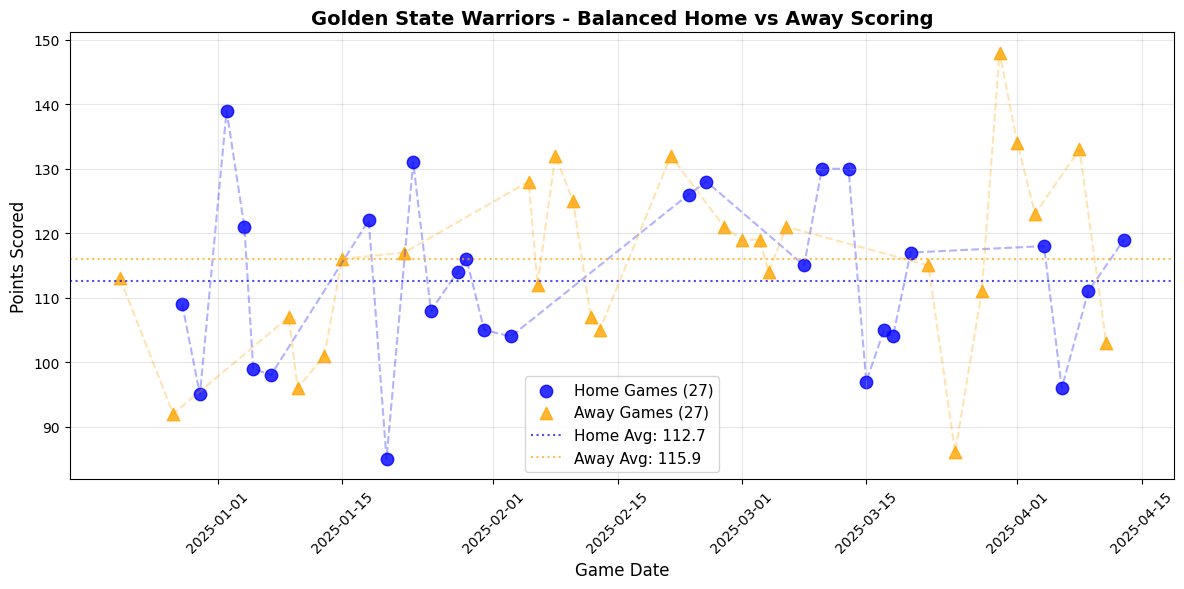


Golden State Warriors Balanced Comparison (27 games each):
Home Record: 17-10 | Away Record: 17-10
Home avg: 112.7 pts | Away avg: 115.9 pts | Home Advantage: -3.3 pts


In [17]:
print("Golden State Warriors Result:")
visualize_team_games(warriors_games, "Golden State Warriors")

Toronto Raptors games and visualize

Toronto Raptors Result:
Balanced comparison: Using 26 most recent games of each type


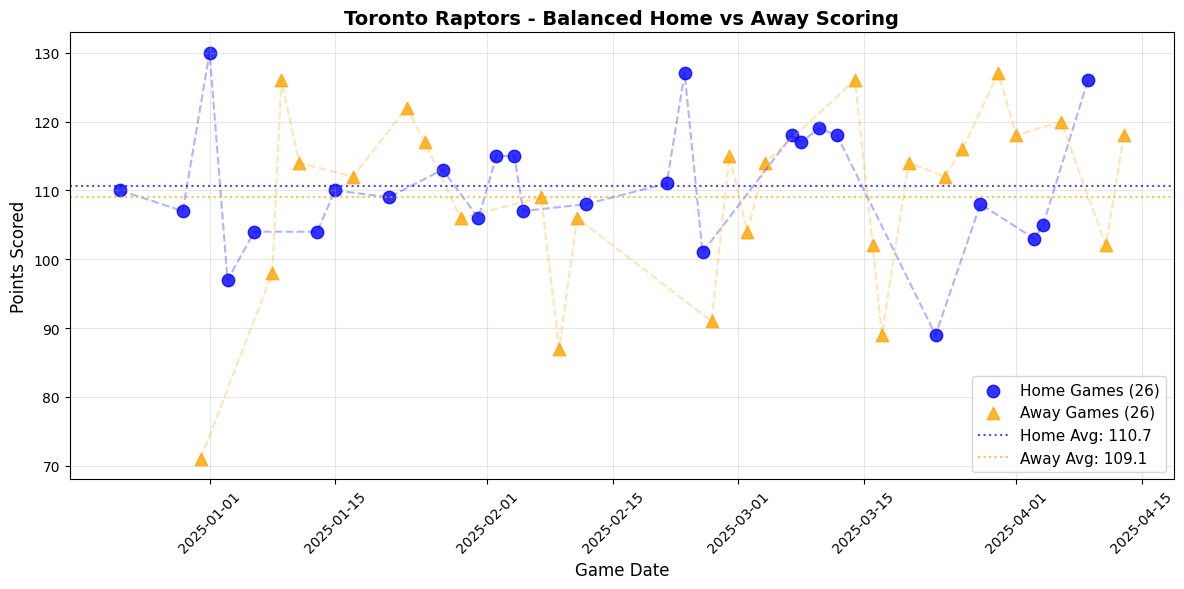


Toronto Raptors Balanced Comparison (26 games each):
Home Record: 12-14 | Away Record: 11-15
Home avg: 110.7 pts | Away avg: 109.1 pts | Home Advantage: +1.6 pts


In [18]:
print("Toronto Raptors Result:")
visualize_team_games(raptors_games, "Toronto Raptors")